# 파이썬으로 배우는 기계학습
# Machine Learning with Python
**************

# 제 4-3 강: 퍼셉트론$^{Perceptron}$ 구현

## 학습 목표
    - 퍼셉트론을 파이썬으로 구현한다. 
    
## 학습 내용
    - 학습 자료의 준비
    - 학습 자료로 연산하기
    - 학습률과 에포크
    - 퍼셉트론 함수 구현

## 1. 퍼셉트론 예제 1 구현

지난 강의에서 퍼셉트론 예제를 하나하나 손으로 계산했습니다. 그러나 이제는 하나하나 손으로 계산하는 것이 아닌, 파이썬 코드로 한번에 계산하고자 합니다.

지난번과 마찬가지로,
그림(4)에 있는 6개 점들을 학습자료로 삼아 두 개의 클래스로 분류하는 이진 퍼셉트론의 가중치를 단계적으로 구현할 것입니다.  최종적으로 두 클래스로 나누는 $\mathbf{w^Tx} = 0$의 직선을 구할 것입니다. 단, 초기 가중치는 계산의 편의를 위하여 $\mathbf{w^T} = [0 \ \ 1 \ \ 0.5]$으로 설정합니다.  학습률은 $\eta = 0.2$, 학습자료는 1번 즉 $\mathbf{x}^{(1)}=[1, 1]$부터 차례로 입력된다고 가정합니다. 각 점의 클래스 레이블 $y = [1, -1, -1, -1, 1, 1]$입니다. 

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/perceptronExample1.png?raw=true" width="400">
<center>그림 1: 퍼셉트론 예제 1</center>

### 1. 학습 자료의 준비$^{Data \ Prep}$

#### 1-1 입력 x
퍼셉트론의 입력 즉 특성값과 가중치를 곱한 값과 편향을 총합한 $z$ 는 다음과 같이 요약할 수 있습니다. 

\begin{equation}
z = w_0x_0 + w_1x_1 + ... + w_m x_m = \sum_{j=0}^{m} x_j w_j = \mathbf{w^Tx}
\end{equation}

이러한 연산을 하기 위하여 주어진 학습 자료들을 Numpy배열로 만들면, 다음과 같습니다. 

`x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0, 1.0], [1.5, -0.5]])`

그런데, 현재의 입력 자료 $\mathbf{x}$에는 $w_0x_0$ 항 즉 편향$^{bias}$을 포함하고 있지 않습니다.  모든 학습 자료들의 첫 번째 요소에 $x^{(i)}_0 = 1$를 추가해야 합니다. 

어떻게 해야 할까요? 

`Numpy`에 이를 위하여 다양한 방법이 있지만, 배열이나 스칼라들을 서로 합쳐주는  `numpy.r_` 과 `numpy.c_` 을 이용하는 것도 한 방법입니다. 참고로 `np.ones(n)`함수는 `n`개의 `1`로 구성된 벡터를 반환합니다. 

In [2]:
import numpy as np
x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0, 1.0], [1.5, -0.5]])
X = np.c_[ np.ones(len(x)), x ]
print('input x:\n', x)
print('input X:\n', X)

input x:
 [[ 1.   1. ]
 [ 2.  -2. ]
 [-1.  -1.5]
 [-2.  -1. ]
 [-2.   1. ]
 [ 1.5 -0.5]]
input X:
 [[ 1.   1.   1. ]
 [ 1.   2.  -2. ]
 [ 1.  -1.  -1.5]
 [ 1.  -2.  -1. ]
 [ 1.  -2.   1. ]
 [ 1.   1.5 -0.5]]


#### 1-2 클래스 레이블
이러한 학습 자료들의 클래스 레이블$^{class \ label} \ y$는 각 표본의 차례대로 다음과 같은 Numpy 배열로 나타낼 수 있습니다. 

In [3]:
y = np.array([1, -1, -1, -1, 1, 1])

#### 1-3 초기 가중치
다음은 가중치를 초기화 해야 하는데, 그 배열은 어떤 크기$^{shape}$이며, 초기값은 어떤 값으로 초기화를 해야 할까요?  

가중치 배열의 차원은 학습 자료의 특성$^{feature}$의 수보다 하나 더 커야 합니다. 왜냐하면, 편향$^{bias}$를 더해 주어야 하기 때문입니다. 이 예제에서 가중치 배열은 특성, x1 과 x2 , 2개와 편향을 합하여 3차원이어야 합니다.  다시 말해서 가중치는 벡터$\mathbb{R}^{m+1}$ 인데, 여기서 m은 학습 자료 특성의 차원이며, +1은 편향을 추가한 것입니다.  

가중치 초기값은 모두 0으로 설정하는 방법과 무작위로 설정하는 방법이 있습니다.  아래 코드에서 __shape__ 은 Numpy배열의 속성이며, 배열의 차원$^{Dimension}$ 즉 크기(6x2)를 나타냅니다. 2개의 특성으로 구성된 자료가 6개 있다는 의미입니다.  `shape`는 `(6, 2)` 파이썬 튜플이므로, 각각은 `shape[0] = 6, shape[1] = 2`입니다.  

`np.zeros(n)`은 n개의 0으로 구성된 배열, `np.ones(n)` n개의 1로 구성된 배열을 반환합니다. 

In [4]:
import numpy as np
x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0,1.0], [1.5, -0.5]]) 
X = np.c_[ np.ones(len(x)), x ]         # trainining samples
y = np.array([1, -1, -1, -1, 1, 1])      # class labels
w = np.array([0, 1.0, 0.5])              # initial weight

우리는 실제 퍼셉트론을 구현할 때에는, 초기 가중치를 프로그래머가 임의로 설정하기 보다는, 랜덤 값으로 설정하는 경우가 많습니다.

`RandomState()`함수를 이용하는 이유는 일정한 무작위 숫자를 반복적으로 발생할 수 있도록 하기 위함입니다. 1 이외에 다른 수를 사용하면, 그에 해당하는 무작위 수를 같은 순서로 발생하도록 무작위 함수를 설정합니다. (왜 일정한 무작위 수를 발생할 필요가 있을까요? 퍼셉트론 연습 문제를 할 때, 초기 가중치를 임의값으로 정한 것처럼, 같은 경우로 실행하여야 디버깅 하기에 편리합니다.)  여기서 사용한 `normal()` 함수는 평균값이 0이며, 표준편차가 0.01에 수렴하는 무작위 수가 `x.shape[1]`개 있는 배열을 반환합니다.

`randnum = np.random.RandomState(1) 
w = randnum.normal(loc=0.0, scale=0.01, size=x.shape[1])`
 
학습자료를 준비하기 까지의 내용을 파이썬 코드로 구현하면 다음과 같습니다.

In [5]:
import numpy as np
x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0,1.0], [1.5, -0.5]]) 
X = np.c_[ np.ones(len(x)), x ]         # trainining samples
y = np.array([1, -1, -1, -1, 1, 1])      # class labels

randnum = np.random.RandomState(1) 
w = randnum.normal(loc=0.0, scale=0.01, size=X.shape[1])

__예제 1__: <br>
x의 shape은? <br>(1) 6 $\times$ 1 (2) 2 $\times$ 6 (3) 6 $\times$ 2 (4) 2 $\times$ 2<br>
__예제풀이__: (3) 6 $\times$ 2


__예제 2__: <br>
X의 shape은? <br>(1) 6 $\times$ 3 (2) 1 $\times$ 6 (3) 3 $\times$ 6 (4) 1 $\times$ 1<br>
__예제풀이__: (1) 6 $\times$ 3

__예제 3__:<br>
w의 shape은? <br>(1) 3 $\times$ 6 (2) 3 $\times$ 3 (3) 1 $\times$ 3 (4) 3 $\times$ 1<br>
__예제풀이__: (4) 3 $\times$ 1

__에제 4__:<br>
$\mathbf{w^Tx}$의 shape은? <br>(1) 6 $\times$ 1 (2) 2 $\times$ 6 (3) 6 $\times$ 2 (4) 2 $\times$ 2<br>
__예제풀이__: (3) 6 $\times$ 1

__예제 5__:<br>
y의 shape은? <br>(1) 2 $\times$ 6 (2) 6 $\times$ 1 (3) 6 $\times$ 2 (4) 2 $\times$ 2<br>

__예제풀이__: (2) 6 $\times$ 1

### 2. 학습 자료로 연산 하기
다음은 각 학습 자료들과 레이블로 학습하여, 자료들을 이진 분류할 수 있는 가중치를  구하려고 합니다.  가중치를 구하여 학습 자료들을 둘로 분류할 수 있는 선 즉 $x_2 = a x_1 + b$ (혹은 $y = ax + b$) 표현하는 일차방정식을 구하는 것입니다.

#### 2-1 __퍼셉트론 알고리즘__
- 각 학습 자료 $x^{(i)}$ 에 대해 $\mathbf{z=w^T x}$를 실행하여 $z$ 을 구한다.
- 활성화 함수(계단 함수)에 $z$를 적용하여 예측$^{predicted}$값 $\hat{y}^{(i)}$를 구한다.
- $\hat{y}^{(i)}$과 $y^{(i)}$와 비교하여 만약, 두 값이 같으면, 아무것도 하지 않는다. 만약 두 값이 다르면, 가중치를 조정한다. 
- 학습 자료를 모두 사용할 때까지 위 과정을 반복한다.  

$\eta$ 값은 0.1로 하고 활성화 함수는 다음과 같다고 가정합니다.
\begin{equation}
  h{(z)} =\begin{cases}
   +1 & \text{$if \ z > 0$} \\
    -1 & \text{$otherwise.$}
  \end{cases}
\end{equation}  

한번에 코드를 작성하기는 매우 어렵지만, 알고리즘을 알고 나서는 알고리즘의 한 스텝 한 스텝을 따라 코드를 작성하면 됩니다.

- <I>각 학습 자료 $x^{(i)}$ 에 대해 $\mathbf{z=w^T x}$를 실행하여 $z$ 을 구한다</I> : 
    - 벡터간의 곱을 요구하므로, 내적을 이용해야 합니다. 따라서 `np.dot()` 함수를 사용하면 되며, `z = np.dot(xi, w)` 와 같이 코드를 작성하면 됩니다.


- 활성화 함수(계단 함수)에 $z$를 적용하여 예측$^{predicted}$값 $\hat{y}^{(i)}$를 구한다 : 
    - 활성화 함수를 구현하면 되는 부분이다, 주어진 활성함수가 간단하므로, `np.where()` 함수를 사용하면 되며 `yhat = np.where( z > 0.0, 1. -1)` 와 같이 코드를 작성하면 됩니다.


- $\hat{y}^{(i)}$과 $y^{(i)}$와 비교하여 만약, 두 값이 같으면, 아무것도 하지 않는다. 만약 두 값이 다르면, 가중치를 조정한다 : 
    - 가중치를 조정하는 부분이다. 가중치 조정 공식을 바로 코드로 옮기면 된다. `delta = eta * (yi - yhat) * xi`로 표현할 수 있다.


- 학습 자료를 모두 사용할 때까지 위 과정을 반복한다 : 
    - 학습 데이터는 여러 개 있을 것이므로 위의 과정을 학습 데이터를 다 검사할 때 까지 반복하도록 한다. 이는 python의 반복문을 사용하면 된다. 

위의 코드들을 합하여 하나로 표현하면 아래와 같습니다.

In [6]:
# Update w using yhat - y
eta = 0.1
for xi, yi in zip(X, y):
    z = np.dot(xi, w)                       # Compute net input, same as np.dot(w.T, x)
    yhat = np.where(z > 0.0, 1, -1)    # Apply step func and get output
    delta = eta * (yi - yhat) * xi        # Compute delta    
    w += delta                             # Adjust weight
    #print('x{}, \t z{} \t (y,yhat)=({},{}), \tdelta{}, \tw{}'.format(xi, z, yi, yhat, delta, np.round(w,2)))
print('w =', w)

w = [-0.18375655  0.29388244  0.49471828]


__Coding Tips__ : 

- zip함수는 여러 개의 list, 배열같은 자료를 묶는 역할을 합니다.  for loop에서 이것을 하나씩 꺼내서$^{slicing}$해서 사용합니다. 참 편리한 방법이죠. zip안에 묶인 자료들의 크기$^{length}$는 같아야 합니다. 
- where함수는 조건문을 원하는 곳에 넣을 수 있어서 편리합니다. 
    - 예를 들면,  `yhat = np.where(z > 0.0, 1, -1)` 다음과 같은 코드와 동일합니다.
   
    ```if z > 0.0:
        yhat = 1
      else:
        yhat = -1```

앞에서 기술한 학습자료 준비와 학습자료 연산하기를 합쳐 하나의 코드로 구현하면 아래와 같습니다.

In [26]:
import numpy as np
x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0,1.0], [1.5, -0.5]]) 
X = np.c_[ np.ones(len(x)), x ]         # trainining samples
y = np.array([1, -1, -1, -1, 1, 1])      # class labels
w = np.array([0, 1.0, 0.5])              # initial weight

# Update w using yhat - y
eta = 0.1
for xi, yi in zip(X, y):
    z = np.dot(xi, w)                       # Compute net input, same as np.dot(w.T, x)
    yhat = np.where(z > 0.0, 1, -1)     # Apply step func and get output
    delta = eta * (yi - yhat) * xi         # Compute delta    
    w += delta                              # Adjust weight
    #print('x{}, \t (y,yhat)=({},{}), \tdelta{}, \tw{}'.format(xi, yi, yhat, delta, np.round(w,2)))
print('w = ', w)

w =  [0.2 0.5 1. ]


#### 2-2. 계단 함수$^{Step \ Function}$

지금까지 우리가 사용해온 활성화 함수는 다음과 같이 양극성 계단함수입니다. 
\begin{align} 
  h(z) &= 
  \begin{cases}
   \ +1 & \text{$if \ z \gt 0$} \\
   \ -1 & \text{$otherwise.$} \\ \tag{2}
  \end{cases}
\end{align}  

그런데 기계학습을 하다 보면, 다음과 같이 극성이 없는 단위 계단 함수를 사용하는 것이 적절한 때가 있습니다. 예를 들면, 클래스 레이블이 1과 -1이 아니라 1과 0라면 다음과 같은 단극성 계단함수를 사용해야 합니다. 

\begin{align} 
  h(z) &= 
  \begin{cases}
   \ 1 & \text{$if \ z \gt 0$} \\
   \ 0 & \text{$otherwise.$} 
  \end{cases}
\end{align} 

프로그램을 어떻게 수정하면 사용자가 어떤 계단 함수를 사용하든지 관계없이 프로그램이 작동할 수 있을까요?

간단합니다. 클래스 레이블이 1가 -1인 것은 클레스 레이블의 값들 중에 가장 큰 값이 1 이고 가장 작은 값이 -1이라고 볼 수 있습니다. 만약에 클래스 레이블이 1과 0인 것은 클래스 레이블의 값들 중에 가장 큰 값이 1이고 가장 작은 값이 0이라고 보는 것이지요.

즉, 클래스 레이블 중, 가장 큰 값을 `maxy`에 저장하고, 가장 작은 값을 `miny`에 저장하는 것입니다. 이렇게 되면, 사용자가 어떤 계단 함수를 사용하든, 사용자가 지정한 클래스 레이블 값들에 맞게, 자연스럽게 활성화 함수가 만들어집니다. 

## epochs = 1, eta = 0.1

In [27]:
x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0,1.0], [1.5, -0.5]]) 
X = np.c_[ np.ones(len(x)), x ]         # trainining samples
y = np.array([1, -1, -1, -1, 1, 1])      # class labels
w = np.array([0, 1.0, 0.5])              # initial weight
maxy, miny = y.max(), y.min()

epochs = 1
eta = 0.1
for _ in np.arange(epochs): 
    for xi, yi in zip(X, y):
        z = np.dot(xi, w)                              # Compute net input, same as np.dot(w.T, x)
        yhat = np.where(z > 0.0, maxy, miny)           # Apply step func and get output
        delta = eta * (yi - yhat) * xi                 # Compute delta    
        w += delta                                     # Adjust weight
print('w = ', w)

w =  [0.2 0.5 1. ]


## epochs = 1, eta = 0.2

In [28]:
x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0,1.0], [1.5, -0.5]]) 
X = np.c_[ np.ones(len(x)), x ]         # trainining samples
y = np.array([1, -1, -1, -1, 1, 1])      # class labels
w = np.array([0, 1.0, 0.5])              # initial weight
maxy, miny = y.max(), y.min()

epochs = 1
eta = 0.2
for _ in np.arange(epochs): 
    for xi, yi in zip(X, y):
        z = np.dot(xi, w)                              # Compute net input, same as np.dot(w.T, x)
        yhat = np.where(z > 0.0, maxy, miny)           # Apply step func and get output
        delta = eta * (yi - yhat) * xi                 # Compute delta    
        w += delta                                     # Adjust weight
print('w = ', w)

w =  [0.  0.8 1.1]


### 3. 학습률, 에포크$^{Epoch}$
퍼셉트론 예제 1에서 학습률은 0.1으로 설정하였으며, 학습 결과로 얻은 가중치는 `[0.2, 0.5, 1]` 이었으며, 이러한 가중치는 학습 자료들을 성공적으로 분류할 수 있었습니다. 

그러면, 학습률을 0.2로 설정한다면, 일반적으로 학습 결과는 더 좋아질까요 아니면 더 나빠질까요? 

이 질문에 대한 정답은 없습니다. 학습률이 작을 경우, 최적의 가중치로 수렴하는데 시간이 오래 걸리는 경우가 있으며, 학습률이 클 경우, 최적의 가중치에 도달하지 못하고 지나칠 수 있습니다. 

퍼셉트론 예제 1에서 학습률이 0.2일 경우의 결과 가중치는 `[0, 0.8, 1.1]`가 나옵니다. 이를 그래프로 그려보면 다음과 같습니다.  

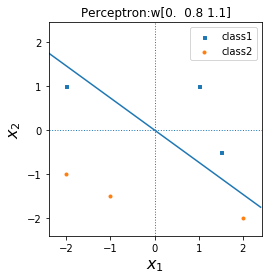

In [29]:
import joy
joy.plot_xyw(X, y, w, X0=True, savefig = "images/perceptronExample1ResultEta0_2.png")

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images//perceptronExample1ResultEta0_2.png?raw=true" width="400">
<center>그림 2: 퍼셉트론 예제 1의 결과($\eta=0.2$)</center>

학습률이 0.2일 때 얻은 가중치로는 학습 데이터를 제대로 분류하지 못하고 있습니다.

그러면, 이 문제를 어떻게 해결해야 할까요?

모든 학습 자료를 다 학습에 사용했지만, 만족스럽지 못한 결과가 나오는 것은 흔히 발생하는 일입니다.  이런 문제에 대한 한 해결 방법은 같은 자료를 가지고 다시 같은 학습 과정을 여러 번 반복하는 것입니다.  기계 학습에서 학습 과정을 한 번 반복하는 것을 1 에포크$^{Epoch}$라고 부릅니다.  에포크는 기계 학습의 다양한 인자들 다른 말로 하이퍼 파라미터$^{Hyperparameters}$들 중에 하나입니다. 

자 그러면, 위에서 작성한 코드를 for 부분을 다시 실행하고 싶은데 어떻게 하려면 어떻게 코딩을 해야 하겠습니까?  다음과 같이 epoch에 대한 for 구문을 추가하면 문제가 해결됩니다. 

여기서 핵심은 프로그램을 처음부터 다시 실행하는 것이 아니라 현재 산출한 가중치를 가지고 for 구문의 부분만 다시 여러 번 실행하길 원하는 것입니다.  다만, 어떤 경우에는 에포크 값에 따라 2번 혹은 어떤 경우에는 20 혹은 2,000번을 실행할 수도 있다는 말입니다. 

## epochs = 2, eta = 0.2

In [30]:
import numpy as np

x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0,1.0], [1.5, -0.5]]) 
X = np.c_[ np.ones(len(x)), x ]         # trainining samples
y = np.array([1, -1, -1, -1, 1, 1])      # class labels
w = np.array([0, 1.0, 0.5])              # initial weight
maxy, miny = y.max(), y.min()

epochs = 2
eta = 0.2
for _ in np.arange(epochs): 
    for xi, yi in zip(X, y):
        z = np.dot(xi, w)                              # Compute net input, same as np.dot(w.T, x)
        yhat = np.where(z > 0.0, maxy, miny)           # Apply step func and get output
        delta = eta * (yi - yhat) * xi                 # Compute delta    
        w += delta                                     # Adjust weight
        #print('x{}, \t (y,yhat)=({},{}), \tdelta{}, \tw{}'.format(xi, yi, yhat, delta, np.round(w,2)))
print('w = ', w)

w =  [0.8 0.6 1.3]


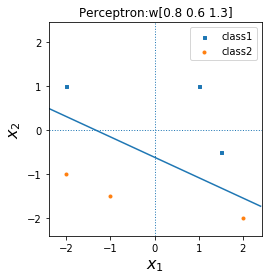

In [31]:
joy.plot_xyw(X, y, w, X0=True)

### 4. 퍼셉트론 함수 구현

지금까지 작성한 코드로도 충분 퍼셉트론의 역할을 수행할 수 있습니다. 그러나, 우리는 좀 더 유연한 프로그램을 개발하길 원합니다.  

에포크가 변할 때마다, 혹은 에타 값을 변경할 때마다, 코드에 있는 변수 값들을 수정하는 것은 추후 컴파일 에러가 발생할 소지를 제공하기도 하며, 좋은 프로그램이 아닙니다. 


이 문제를 해결하기 위한 합리적인 방법 중에 하나는 현재 프로그램을 함수로 전환하여 여러 경우에 대비하여 쉽게 활용할 수 있는 재코딩하는 것입니다.  사용자가 자주 바꿀 수 있는 부분을 인자로 받아 알고리즘을 수행하고, 최종 가중치를 반환하는 perceptron 함수를 만들어 봅시다.  

사용자가 `perceptron()`함수에 넘겨주어야 할 인자들은 어느 것이 있겠습니까? 다음과 같은 인자들을 생각할 수 있습니다. 
- 학습 자료 
- 클래스 레이블
- 학습률
- 반복 횟수$^{Epoch}$ 
- 동일한 난수 발생을 위한 시드$^{Seed}$ 

이제 이러한 인자들을 갖고 함수를 작성하면 아래와 같습니다.
- 학습 자료는 `X`로
- 클래스 레이블은 `y`로
- 학습률은 `eta`로
- 반복 횟수는 `epochs`로
- 동일한 난수 발생을 위한 시드는 `random_seed`로 표현합니다.

In [16]:
#%%writefile code/perceptronV1.py
def perceptronV1(X, y, w = None, eta=0.1, epochs=10, random_seed=1):
    if w is None:
        randnum = np.random.RandomState(random_seed) 
        w = randnum.normal(loc=0.0, scale=0.01, size=X.shape[1])
    maxy, miny = y.max(), y.min()

    for _ in range(epochs): 
        for xi, yi in zip(X, y):
            z = np.dot(xi, w)                              # Compute net input, same as np.dot(w.T, x)
            yhat = np.where(z >= 0.0, maxy, miny)          # Apply step func and get output
            delta = eta * (yi - yhat) * xi                 # Compute delta    
            w += delta                                     # Adjust weight
            print('{},{}={}'.format(xi, yi, w))
    return w

함수 `perceptronV1()`에서 X, y는 반드시 함수 호출자가 넘겨주어야 할 인자들이며, 정해진 위치대로 넘겨 주어야 합니다.  그러나, 다른 인자들은 선택적으로 필요에 따라 넘겨 줄 수 있는 인자들입니다. 만약에, 선택적 인자들이 넘겨지지 않을 경우, 디폴트 인자 값들을 사용하고, 가중치도 난수를 발생하여 사용합니다. 

다음은 학습률 eta = 0.2, 반복횟수 epochs = 2로 실행하는 경우입니다.  

<img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/perceptronExample1ResultEpoch.png?raw=true" width="400">
<center>그림 3: 퍼셉트론 예제 1의 결과($\eta=0.2, epoch=2$)</center>

이를 구현한 코딩은 다음과 같습니다. 

참고로, `plot_xyw()` 함수에 x대신 X를 인자로 사용할 경우, `X0=True`인자를 함께 사용해야 합니다. 가중치 w를 인자로 전달하면, 직선으로 나타낼 수 있는 분별식(Decision boundary)을 도식화합니다. 

w:  [0.8 0.6 1.3]


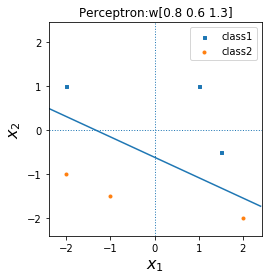

In [9]:
import matplotlib.pyplot as plt  
import numpy as np
%matplotlib inline
%run code/plot_xyw.py

x = np.array([[1.0, 1.0], [2.0, -2.0], [-1.0,-1.5], [-2.0, -1.0], [-2.0,1.0], [1.5, -0.5]]) 
X = np.c_[ np.ones(len(x)), x ]         # trainining samples
y = np.array([1, -1, -1, -1, 1, 1])      # class labels
w = np.array([0, 1.0, 0.5])              # initial weight
w = perceptronV1(X, y, w, eta=0.2, epochs=2)
print('w: ', w)
plot_xyw(X, y, w, X0=True, savefig='images/perceptronExample1ResultEpoch.png')

## 학습 정리
- 학습 자료의 준비
- 학습 자료로 연산하기
- 학습률과 에포크
- 퍼셉트론 함수 구현

-----------